# CHEERS HG19 Calderon et al.

**Created**: 3 March 2022

I ran CHEERS on the following set of SNPs. In all cases, I included the SNPs and any tagging SNPs ($R^2 > 0.8$).

1. Lead eSNPs from Initial cis-eQTL Mapping
2. Conditional eSNPs from cis-eQTL Mapping
3. Lead eSNPs that are sepsis-specific based on Katie's mashR analysis
4. Lead eSNPs that are sepsis-specific and stronger in GAInS based on Katie's mashR analysis

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(patchwork)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## All Cell Conditions

### Load Data

In [3]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [4]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [5]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps.log", sep="\t")

In [6]:
lineages <- read.csv("03_Functional_Interpretation/data/Calderon_et_al_lineages.csv")

In [7]:
head(lineages)

,Lineage,Cell_Type
,<chr>,<chr>
1,B,Bulk_B
2,B,Mem_B
3,B,Naive_B
4,B,Plasmoblasts
5,CD8,CD8pos_T
6,CD8,Central_memory_CD8pos_T


The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`), the number of SNP lists tested (6), and the number of times the testing is done (2).

In [8]:
critical.value <- qnorm(0.05 / (nrow(lead.p.vals) * 6 * 2), lower.tail=F)

In [9]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,373474,1106.0163
2,Conditional cis-eQTL,373474,993.8114
3,Conditional Secondary cis-eQTL,373474,1723.3465
4,Non-Sepsis-Specific cis-eQTL,373474,1204.5148
5,Sepsis-Specific cis-eQTL,373474,2136.2629
6,Sepsis-Specific Up cis-eQTL,373474,3460.3136


In [10]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,290310.3,Lead cis-eQTL
2,Bulk_B-U,368604.9,Lead cis-eQTL
3,CD8pos_T-S,312369.2,Lead cis-eQTL
4,CD8pos_T-U,412439.9,Lead cis-eQTL
5,Central_memory_CD8pos_T-S,323336.8,Lead cis-eQTL
6,Central_memory_CD8pos_T-U,405014.4,Lead cis-eQTL


In [11]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,1.0000000,Lead cis-eQTL
2,Bulk_B-U,0.9999946,Lead cis-eQTL
3,CD8pos_T-S,1.0000000,Lead cis-eQTL
4,CD8pos_T-U,0.0000000,Lead cis-eQTL
5,Central_memory_CD8pos_T-S,1.0000000,Lead cis-eQTL
6,Central_memory_CD8pos_T-U,0.0000000,Lead cis-eQTL


### Enrichment of Different SNP Lists

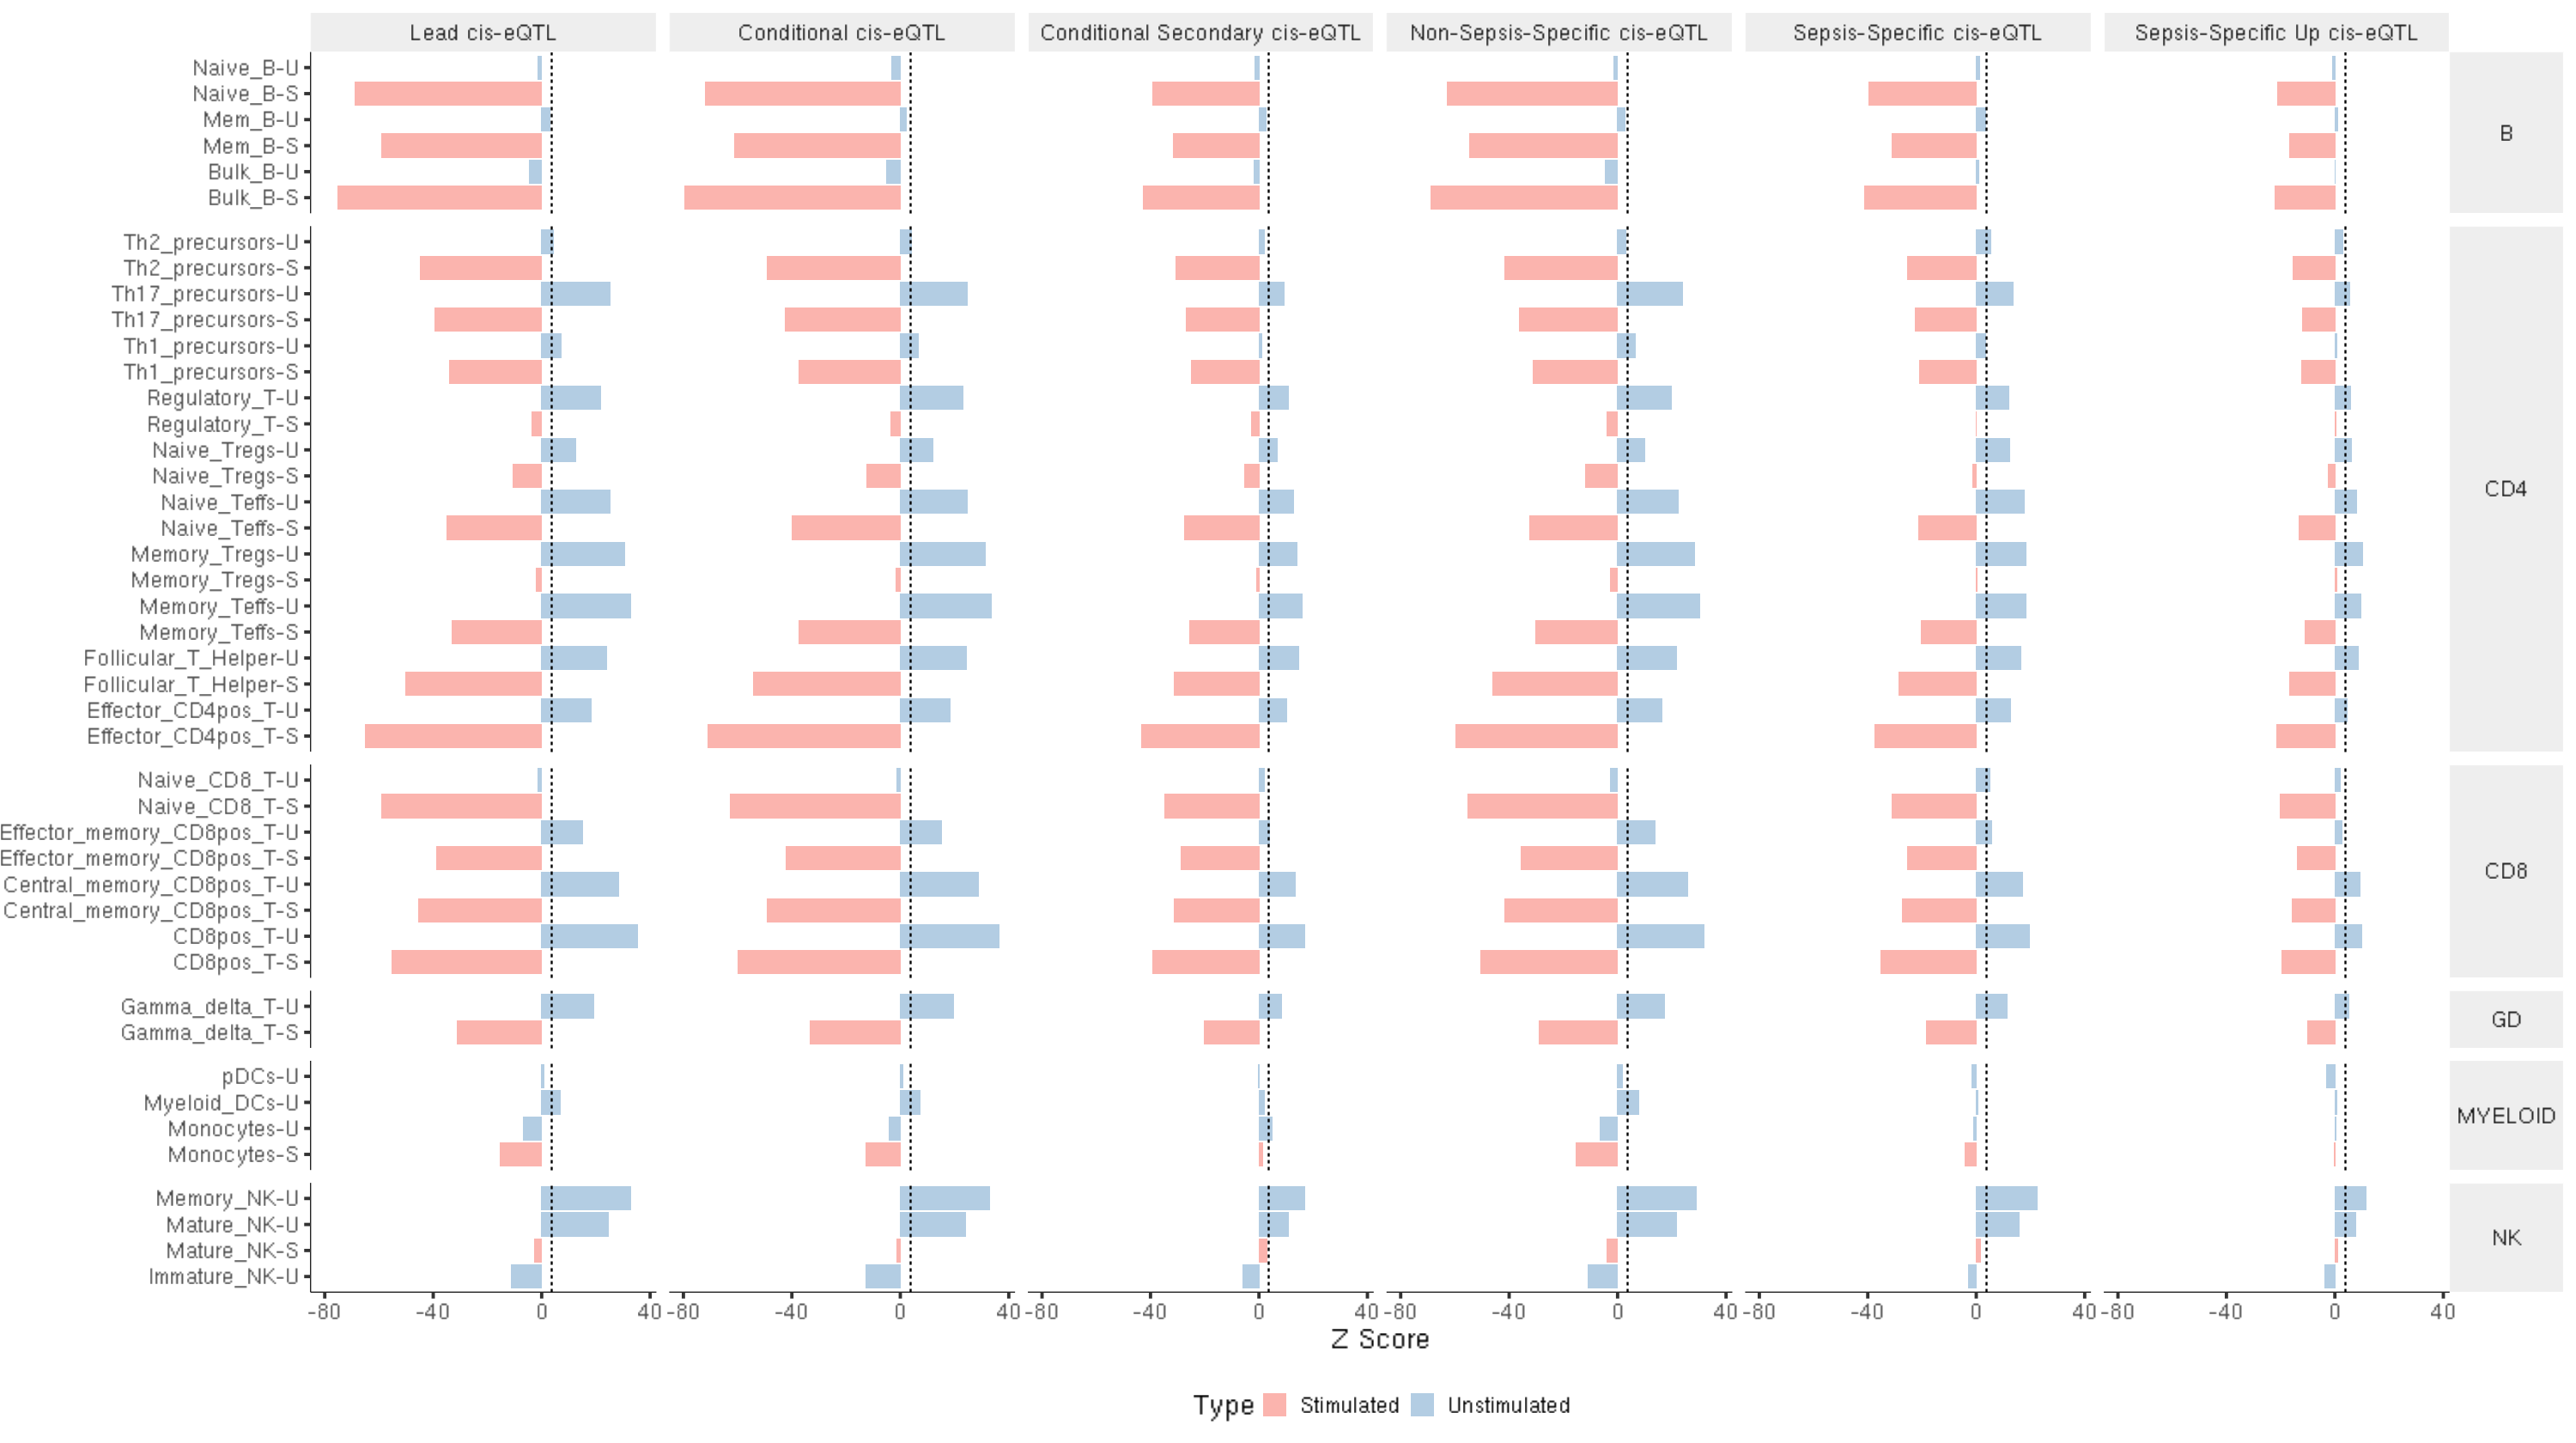

In [12]:
options(repr.plot.width=25, repr.plot.height=14)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    dplyr::mutate(Type=ifelse(grepl("-S$", Condition), "Stimulated", "Unstimulated")) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z, fill=Type), stat="identity") +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_all.svg", width=25, height=14)

## Stimulated Cell Conditions

### Load Data from Stimulated Cell Types

In [13]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [14]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [15]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated.log", sep="\t")

In [16]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,373474,1111.0261
2,Conditional cis-eQTL,373474,998.1353
3,Conditional Secondary cis-eQTL,373474,1730.7140
4,Non-Sepsis-Specific cis-eQTL,373474,1210.0215
5,Sepsis-Specific cis-eQTL,373474,2145.3366
6,Sepsis-Specific Up cis-eQTL,373474,3472.8575


In [17]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,320778.1,Lead cis-eQTL
2,CD8pos_T-S,354321.4,Lead cis-eQTL
3,Central_memory_CD8pos_T-S,357613.4,Lead cis-eQTL
4,Effector_CD4pos_T-S,325517.7,Lead cis-eQTL
5,Effector_memory_CD8pos_T-S,366181.3,Lead cis-eQTL
6,Follicular_T_Helper-S,353060.4,Lead cis-eQTL


In [18]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,1,Lead cis-eQTL
2,CD8pos_T-S,1,Lead cis-eQTL
3,Central_memory_CD8pos_T-S,1,Lead cis-eQTL
4,Effector_CD4pos_T-S,1,Lead cis-eQTL
5,Effector_memory_CD8pos_T-S,1,Lead cis-eQTL
6,Follicular_T_Helper-S,1,Lead cis-eQTL


### Enrichment of Different SNP Lists

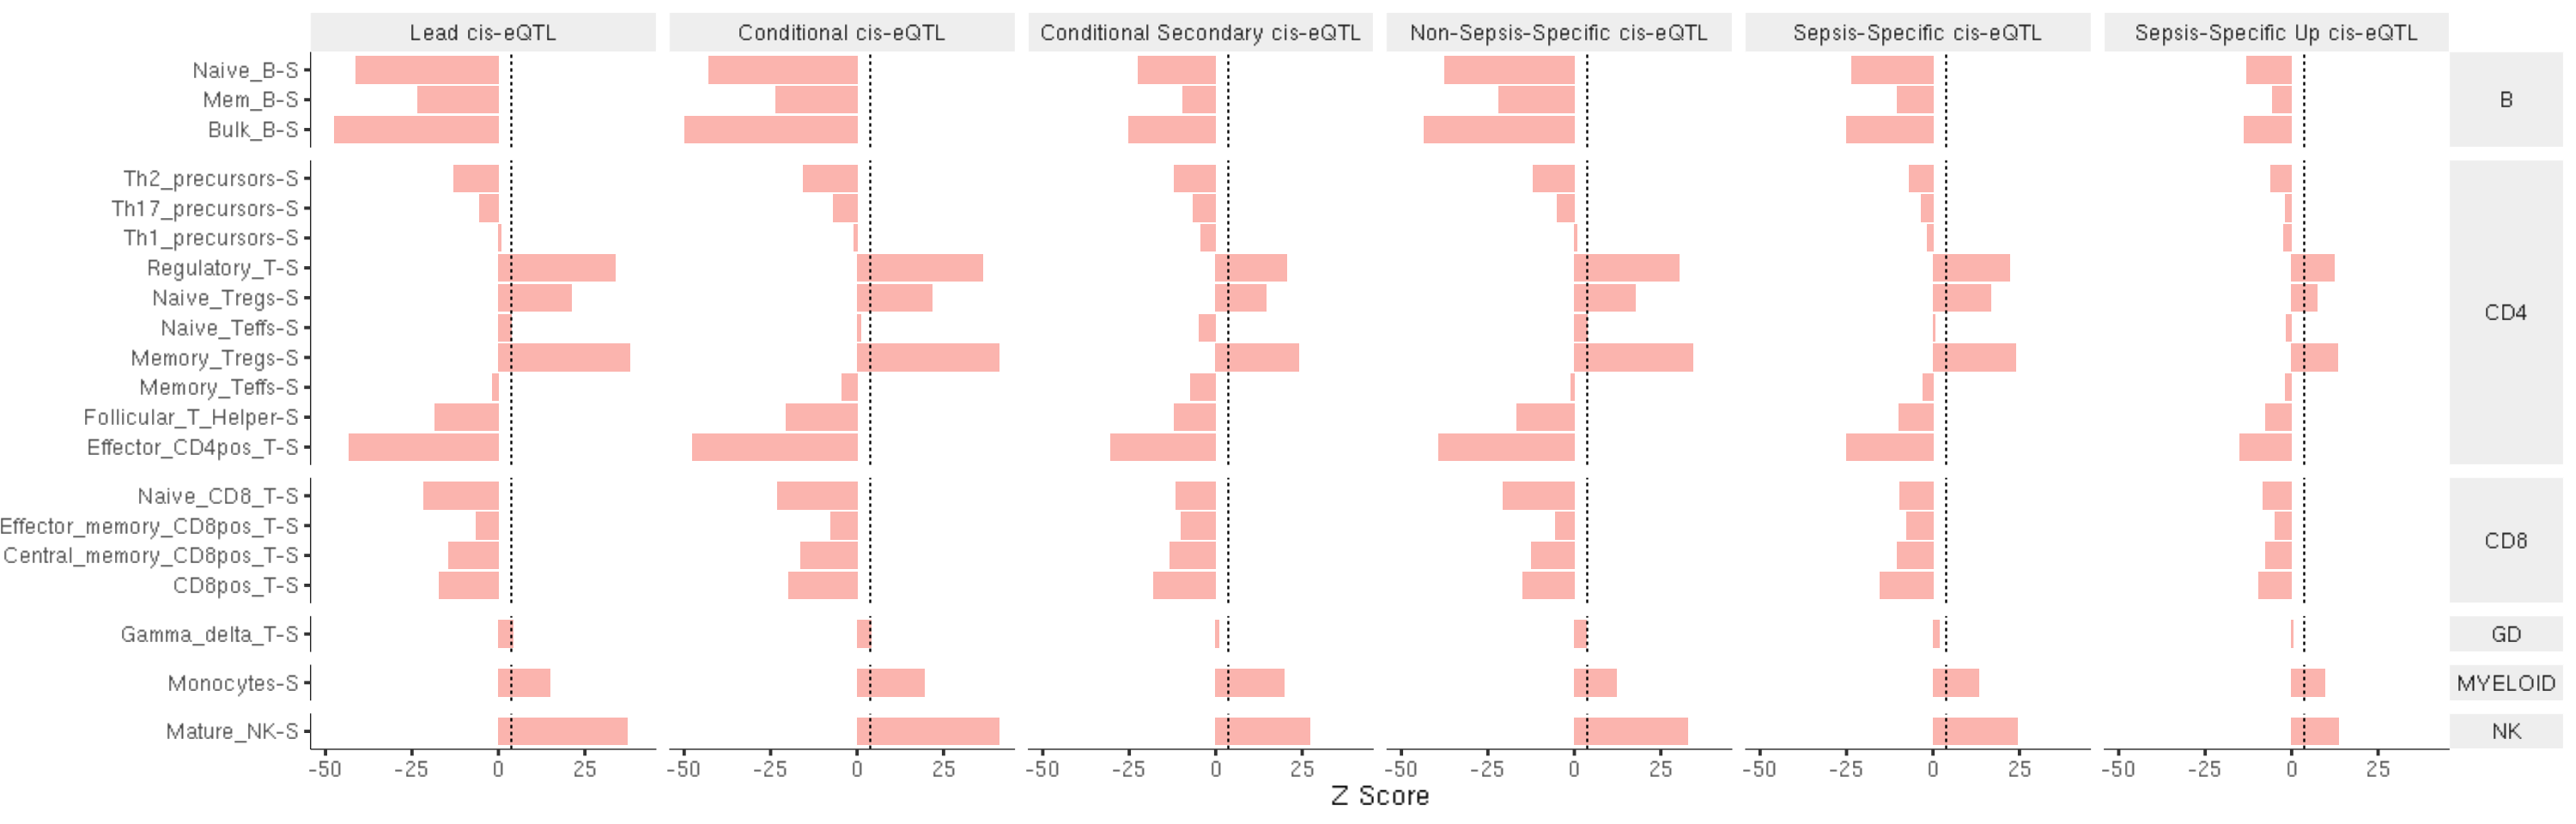

In [19]:
options(repr.plot.width=25, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_all.svg", width=25, height=8)

### Enrichment of Secondary cis-eQTL

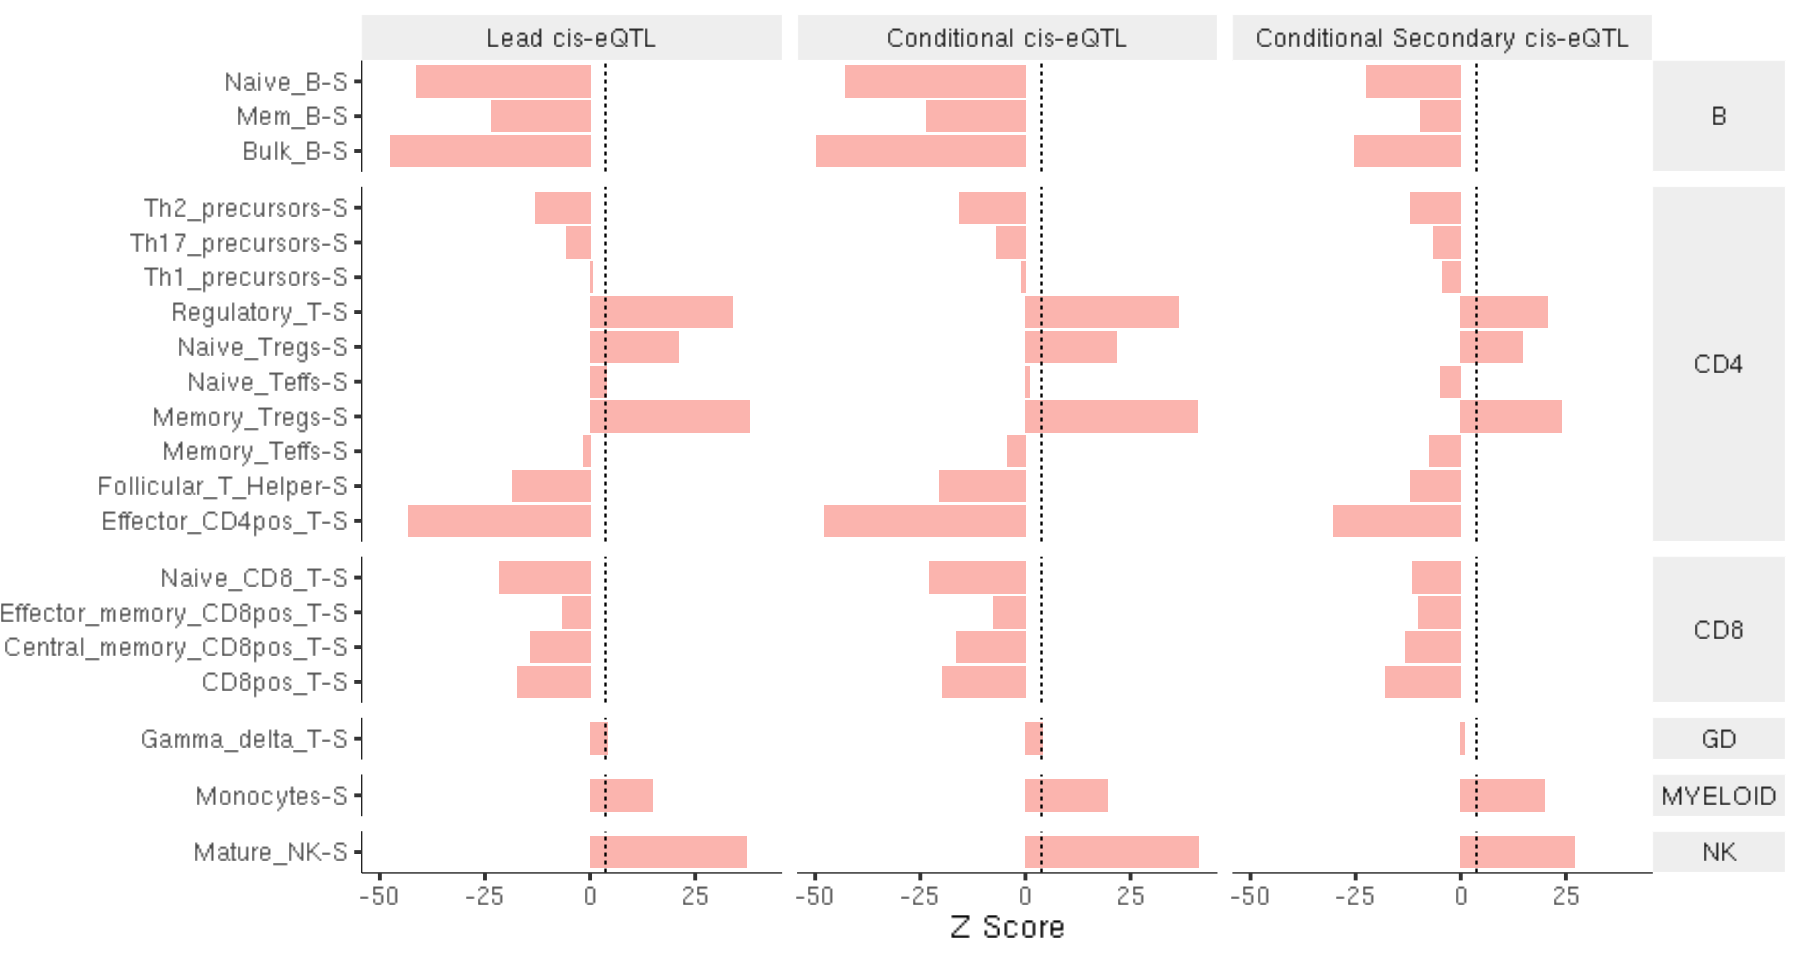

In [20]:
options(repr.plot.width=15, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL"))) %>%
    dplyr::filter(SNPs %in% c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_secondary_signals.svg", width=15, height=8)

### Enrichment of Sepsis-Specific cis-eQTL

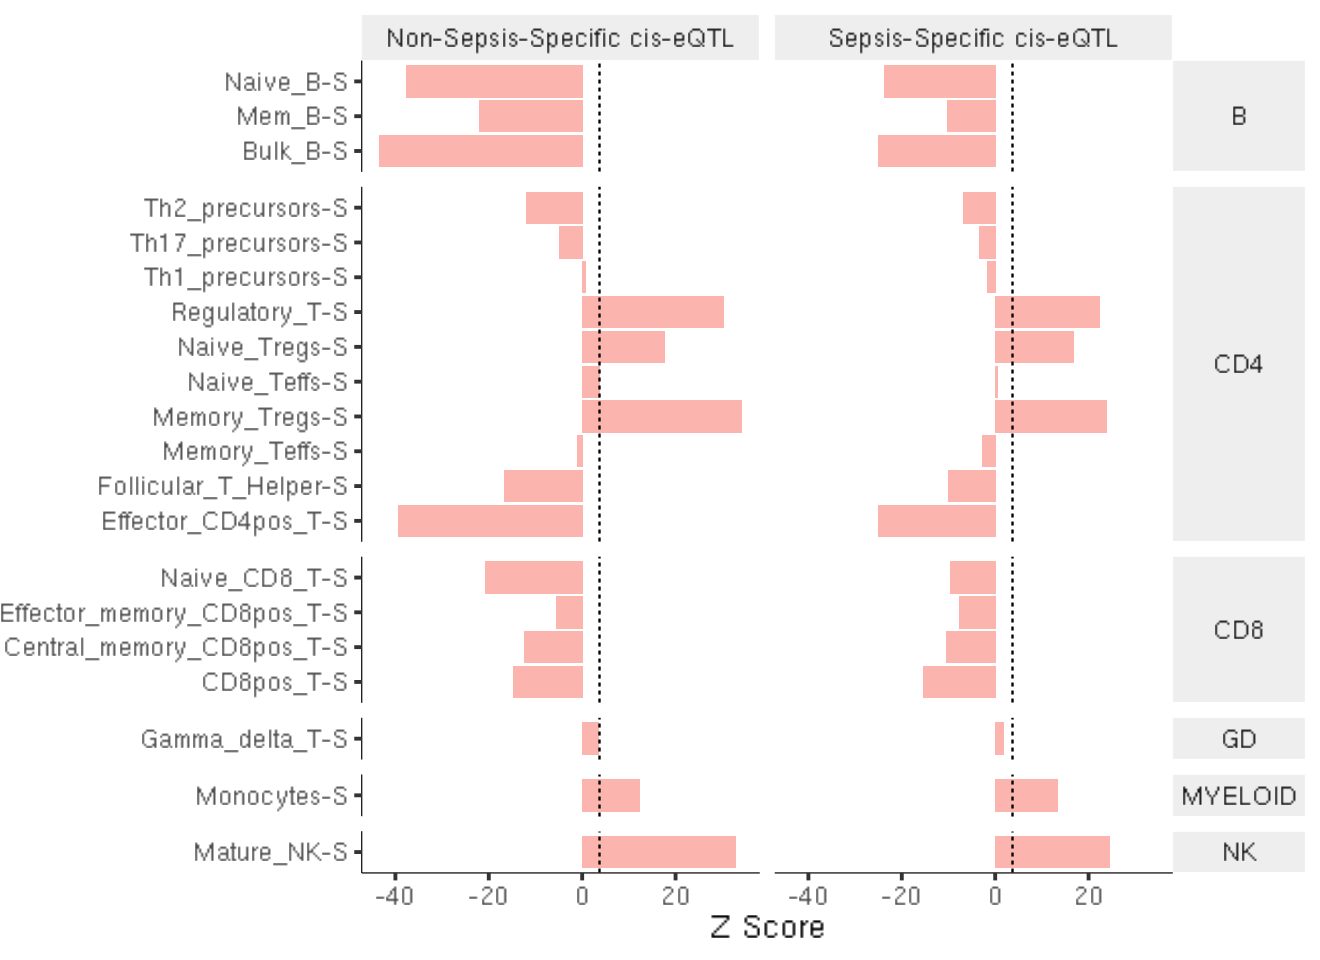

In [21]:
options(repr.plot.width=11, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs %in% c("Sepsis-Specific cis-eQTL", "Non-Sepsis-Specific cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_sepsis_specific.svg", width=11, height=8)

## Unstimulated Cell Conditions

### Load Data from Unstimulated Cell Types

In [22]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [23]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [24]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated.log", sep="\t")

In [25]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,373474,1103.9271
2,Conditional cis-eQTL,373474,992.0635
3,Conditional Secondary cis-eQTL,373474,1721.0941
4,Non-Sepsis-Specific cis-eQTL,373474,1202.5652
5,Sepsis-Specific cis-eQTL,373474,2131.7687
6,Sepsis-Specific Up cis-eQTL,373474,3454.5357


In [26]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-U,344277.8,Lead cis-eQTL
2,CD8pos_T-U,381875.4,Lead cis-eQTL
3,Central_memory_CD8pos_T-U,383033.7,Lead cis-eQTL
4,Effector_CD4pos_T-U,370238.1,Lead cis-eQTL
5,Effector_memory_CD8pos_T-U,371320.8,Lead cis-eQTL
6,Follicular_T_Helper-U,375886.1,Lead cis-eQTL


In [27]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-U,1.000000e+00,Lead cis-eQTL
2,CD8pos_T-U,1.365574e-14,Lead cis-eQTL
3,Central_memory_CD8pos_T-U,0.000000e+00,Lead cis-eQTL
4,Effector_CD4pos_T-U,9.983120e-01,Lead cis-eQTL
5,Effector_memory_CD8pos_T-U,9.744402e-01,Lead cis-eQTL
6,Follicular_T_Helper-U,1.444299e-02,Lead cis-eQTL


### Enrichment of Different SNP Lists

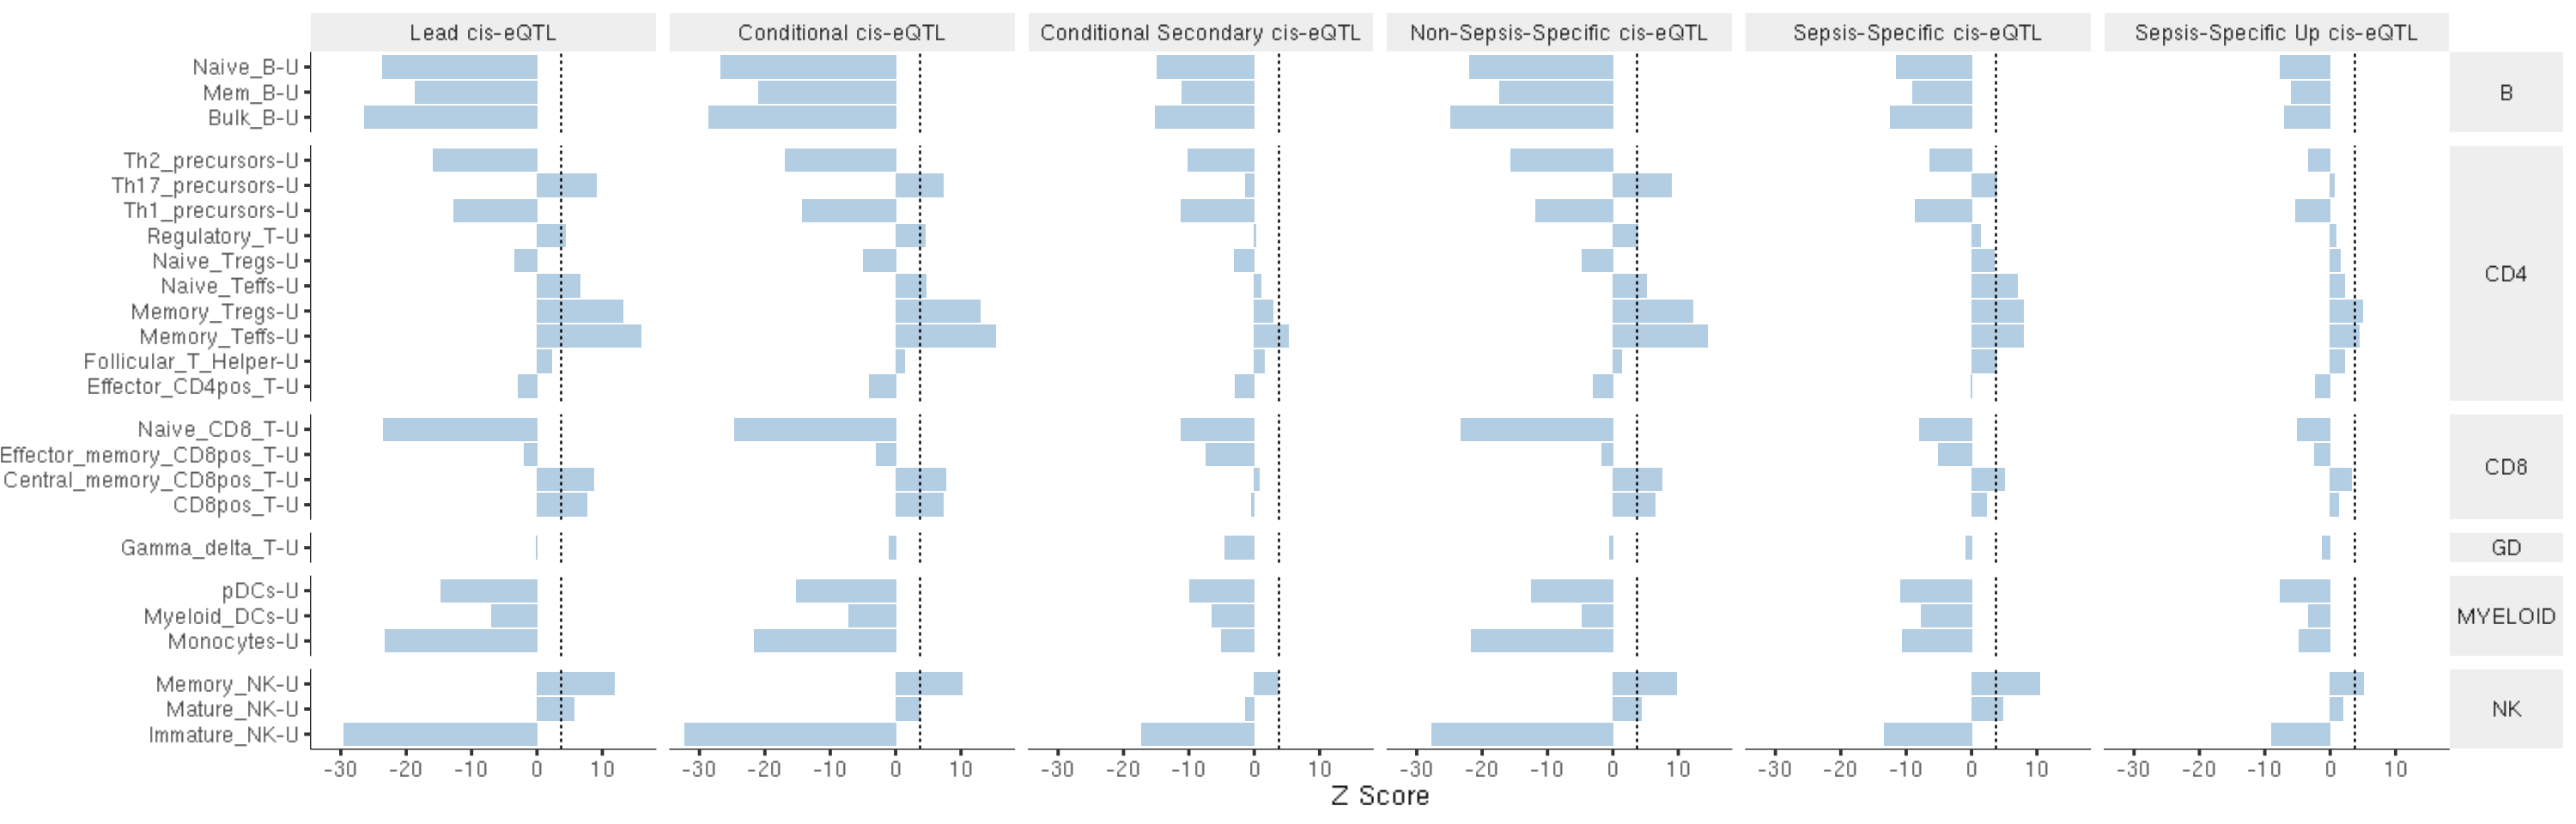

In [28]:
options(repr.plot.width=25, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_all.svg", width=25, height=8)

### Enrichment of Secondary cis-eQTL

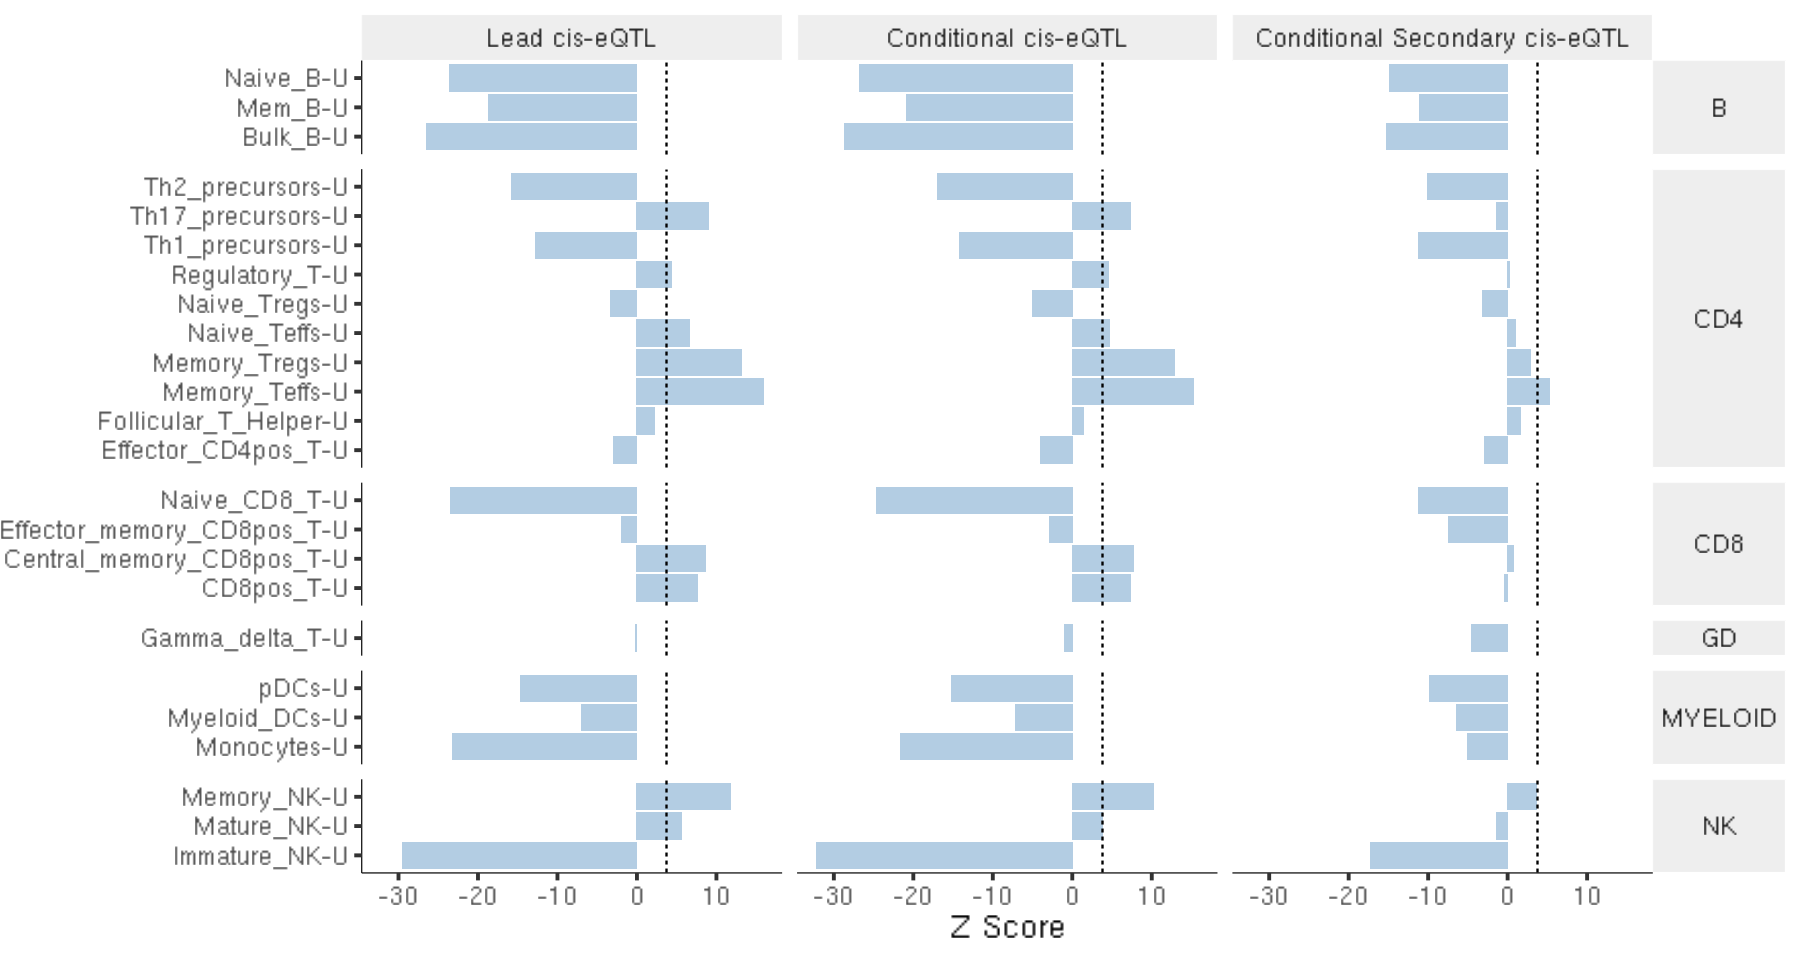

In [29]:
options(repr.plot.width=15, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL"))) %>%
    dplyr::filter(SNPs %in% c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_secondary_signals.svg", width=15, height=8)

### Enrichment of Sepsis-Specific cis-eQTL

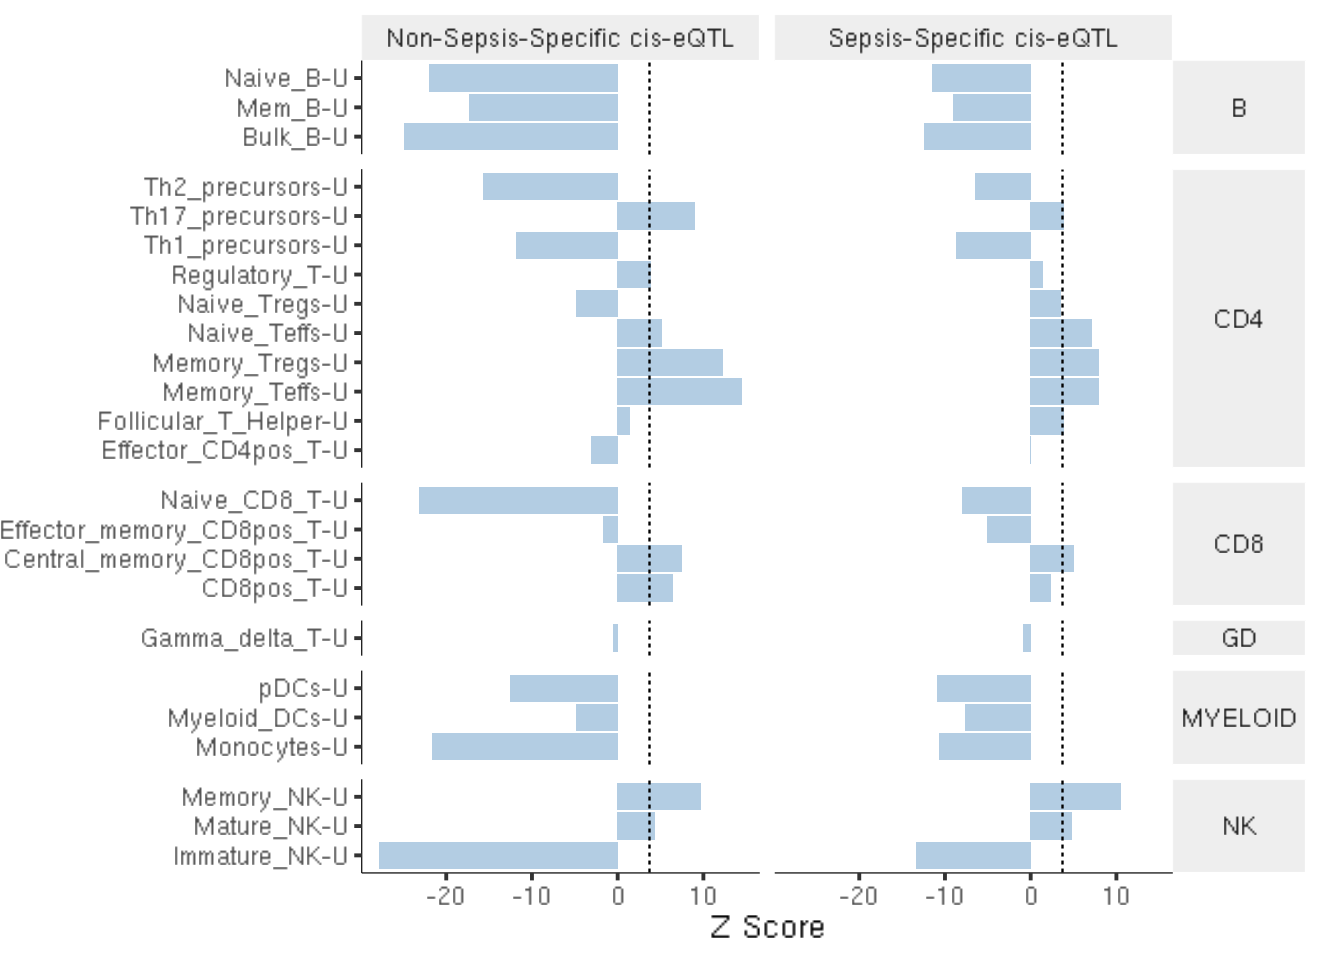

In [30]:
options(repr.plot.width=11, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs %in% c("Sepsis-Specific cis-eQTL", "Non-Sepsis-Specific cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_sepsis_specific.svg", width=11, height=8)

## Peaks Driving Cell-Type-Specific Enrichment

CHEERS works on cell-type-specificity scores for peaks. We can use these specificity scores to understand which peaks are driving the enrichment signal.

In [83]:
cis.eqtl <- readRDS("~/gains_team282/eqtl/cisresults/ciseqtl_all.rds")

In [84]:
stimulated.norm <- fread("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/normalized/Calderon_et_al_stimulated_counts_normToMax_quantileNorm_euclideanNorm.txt") %>%
    as.data.frame() %>%
    dplyr::mutate(ID=paste0(chr, ":", start, "-", end))

rownames(stimulated.norm) <- stimulated.norm$ID

stimulated.norm <- stimulated.norm %>%
    dplyr::select(everything(), -chr, -start, -end, -ID) %>%
    apply(., 2, function(x) { rank(x, ties.method="min") }) %>%
    as.data.frame()

In [92]:
non.sepsis.overlaps <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_SNPsOverlappingPeaks.txt", sep="\t", header=TRUE) %>%
    dplyr::filter(snp %in% cis.eqtl$snps)

sepsis.overlaps <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_SNPsOverlappingPeaks.txt", sep="\t", header=TRUE) %>%
    dplyr::filter(snp %in% cis.eqtl$snps)

In [94]:
length(intersect(non.sepsis.overlaps$snp, sepsis.overlaps$snp))

[1] 1536

In [91]:
intersect(
    non.sepsis.overlaps$ID[order(stimulated.norm[non.sepsis.overlaps$ID,"Monocytes-S"], decreasing=TRUE)],
    sepsis.overlaps$ID[order(stimulated.norm[sepsis.overlaps$ID,"Monocytes-S"], decreasing=TRUE)]
) %>% length()

[1] 4183

In [90]:
stimulated.norm[intersect(
    non.sepsis.overlaps$ID[order(stimulated.norm[non.sepsis.overlaps$ID,"Monocytes-S"], decreasing=TRUE)],
    sepsis.overlaps$ID[order(stimulated.norm[sepsis.overlaps$ID,"Monocytes-S"], decreasing=TRUE)]
),"Monocytes-S"] %>% mean()

[1] 406344

In [82]:
mean(stimulated.norm[non.sepsis.overlaps$ID, "Monocytes-S"])

[1] 388257.4

In [73]:
dim(non.sepsis.overlaps)

[1] 31755     4